# Testing for STREL

First import all the necessary libraries and operators from STREL:

In [1]:
import matplotlib.pyplot as plt
import torch
import itertools

from torcheck.strel import (
    Reach, Escape, Somewhere, Everywhere, Surround, Atom, Not, Or
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Test Settings

In [2]:
B, N, F, T = 1, 7, 3, 5  # batch size, number of nodes, features, timestep
signal = torch.zeros((B, N, F, T), dtype=torch.float32)

# Coordinates (x, y) of the 7 nodes in time
signal[0, 0, 0, :] = 0.0                      # x0
signal[0, 0, 1, :] = 0.0                      # y0

signal[0, 1, 0, :] = torch.linspace(0, 2, T)  # x1 
signal[0, 1, 1, :] = 0.0                      # y1

signal[0, 2, 0, :] = 1.0                      # x2
signal[0, 2, 1, :] = 1.0                      # y2

signal[0, 3, 0, :] = 2.0                      # x3
signal[0, 3, 1, :] = 2.0                      # y3

signal[0, 4, 0, :] = torch.linspace(0.0, 1.0, T)  # x4 
signal[0, 4, 1, :] = torch.linspace(1.0, 0.0, T)  # y4 

signal[0, 5, 0, :] = 1.5                            # x5
signal[0, 5, 1, :] = torch.linspace(0.0, 2.0, T)    # y5 

signal[0, 6, 0, :] = torch.linspace(0.0, 2.0, T)  # x6 
signal[0, 6, 1, :] = torch.linspace(2.0, 0.0, T)  # y6 

# Third feature values (activation signal for Atom)
signal[0, :, 2, :] = torch.tensor([
#    t_0 | t_1 | t_2 | t_3 | t_4
    [0.4,  0.6,  0.2,  0.8,  0.9],  # node 0
    [0.1,  0.3,  0.7,  0.2,  0.1],  # node 1
    [0.9,  0.9,  0.9,  0.9,  0.9],  # node 2
    [0.0,  0.1,  0.2,  0.3,  0.4],  # node 3
    [0.6,  0.6,  0.6,  0.6,  0.6],  # node 4
    [0.2,  0.2,  0.2,  0.2,  0.2],  # node 5
    [1.0,  0.9,  0.8,  0.7,  0.6],  # node 6
])

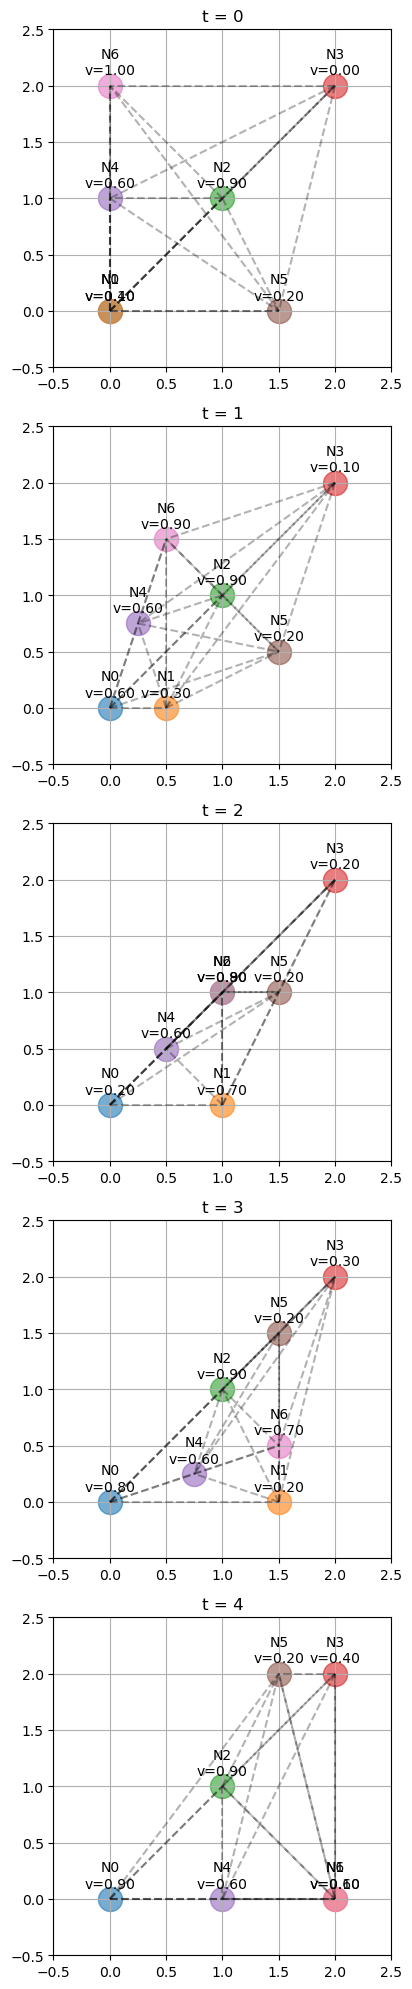

In [3]:
T = signal.shape[-1]
N = signal.shape[1]

# Plot 5x1
fig, axes = plt.subplots(5, 1, figsize=(6, 20))  

for t in range(T):
    ax = axes[t] 

    positions = {}
    for n in range(N):
        x = signal[0, n, 0, t].item()
        y = signal[0, n, 1, t].item()
        positions[n] = (x, y)

    for i, j in itertools.combinations(range(N), 2):
        x0, y0 = positions[i]
        x1, y1 = positions[j]
        ax.plot([x0, x1], [y0, y1], 'k--', alpha=0.3)

    for n in range(N):
        x, y = positions[n]
        val = signal[0, n, 2, t].item()
        ax.scatter(x, y, s=300, alpha=0.6)
        ax.text(x, y + 0.1, f"N{n}\nv={val:.2f}", ha='center')

    ax.set_title(f"t = {t}")
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.grid(True)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [4]:
def print_table(title, tensor):
    # ✅ Accetta solo [B, N, 1, T]
    assert tensor.dim() == 4 and tensor.size(2) == 1, \
        f"Atteso [B,N,1,T], trovato {list(tensor.shape)}"

    # rimuovo la dimensione del canale singleton
    tensor = tensor.squeeze(2)  # → [B, N, T]

    B, N, T = tensor.shape
    print(f"\n{title}")
    header = "| Nodo | " + " | ".join([f"t={t}" for t in range(T)]) + " |"
    print(header)
    print("|------|" + "------|" * T)
    for n in range(N):
        row = [f"{tensor[0, n, t].item(): .2f}" for t in range(T)]
        print(f"|  {n}   | " + " | ".join(row) + " |")

## Escape Test

First we just check if the output size is correct

In [5]:
# -------------------------------
# TEST: Escape (Boolean & Quantitative)
# -------------------------------

# Atomic predicate: x_2 ≥ 0.5
atom = Atom(var_index=2, threshold=0.5, lte=False)

# Escape d1 = 0.5, d2 = 2.0
escape_op = Escape(child=atom, d1=0.5, d2=2.0)

# --- BOOLEAN SEMANTICS ---
boolean_result = escape_op.boolean(signal, evaluate_at_all_times=True)
# print("\n[Boolean] Risultato:", boolean_result.int())

# --- QUANTITATIVE SEMANTICS ---
signal.requires_grad_()  # differentiability
quant_result = escape_op.quantitative(signal, evaluate_at_all_times=True)

# print("\n[Quantitative] Risultato:", quant_result)
        
print_table("Escape Boolean", boolean_result.int())
print_table("Escape Quantitative", quant_result)


Escape Boolean
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  1   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  2   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  3   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  4   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  5   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  6   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |

Escape Quantitative
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   | -0.10 |  0.10 | -0.30 |  0.30 |  0.40 |
|  1   | -0.40 | -0.20 |  0.20 | -0.30 | -0.40 |
|  2   |  0.40 |  0.40 |  0.20 |  0.30 |  0.40 |
|  3   | -0.50 | -0.40 | -0.30 | -0.20 | -0.10 |
|  4   |  0.10 |  0.10 |  0.10 |  0.10 |  0.10 |
|  5   | -0.30 | -0.30 | -0.30 | -0.30 | -0.30 |
|  6   |  0.40 |  0.40 |  0.20 |  0.20 |  0.10 |


Checking differentiability now

In [6]:
# Backward test
loss = quant_result.sum()
loss.backward()
print("[Gradiente Quantitative] signal.grad is None?", signal.grad is None)

# Backward test
loss = boolean_result.sum()
loss.backward()
print("\n[Gradiente Boolean] signal.grad is None?", signal.grad is None)

[Gradiente Quantitative] signal.grad is None? False

[Gradiente Boolean] signal.grad is None? False


## Reach Test

In [7]:
# -------------------------------
# TEST: Reach (Boolean, Bounded)
# -------------------------------

# Atomic predicate 1: x_2 >= 0.5
phi = Atom(var_index=2, threshold=0.5, lte=False)

# Atomic predicate 2: x_2 >= 0.8
psi = Atom(var_index=2, threshold=0.8, lte=False)

# Reach in [0.5, 2.0]
reach_op = Reach(
    left_child=phi,
    right_child=psi,
    d1=0.5,
    d2=2.0,
    is_unbounded=False,
    distance_domain_min=0.0,
    distance_domain_max=5.0 
)

# --- BOOLEAN SEMANTICS ---
reach_boolean = reach_op.boolean(signal, evaluate_at_all_times=True)
print_table("Reach Boolean (bounded)", reach_boolean.int())

# Backward test
loss = reach_boolean.sum()
loss.backward()
print("\n[Gradiente Boolean] signal.grad is None?", signal.grad is None)


Reach Boolean (bounded)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  1   |  0.00 |  0.00 |  1.00 |  0.00 |  0.00 |
|  2   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |
|  3   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  4   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |
|  5   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  6   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |

[Gradiente Boolean] signal.grad is None? False


In [8]:
# -------------------------------
# TEST: Reach (Boolean, Unbounded)
# -------------------------------

phi = Atom(var_index=2, threshold=0.5, lte=False)
psi = Atom(var_index=2, threshold=0.8, lte=False)

# Reach UNBOUNDED
reach_unbounded_op = Reach(
    left_child=phi,
    right_child=psi,
    d1=0.5,
    d2=10000,  # Internally ignored in unbounded, but needed for fallback
    is_unbounded=True,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

# --- BOOLEAN SEMANTICS ---
reach_unbounded_boolean = reach_unbounded_op.boolean(signal, evaluate_at_all_times=True)
print_table("Reach Boolean (unbounded)", reach_unbounded_boolean.int())

# Backward test
loss = reach_unbounded_boolean.sum()
loss.backward()
print("\n[Gradiente Boolean Unbounded] signal.grad is None?", signal.grad is None)


Reach Boolean (unbounded)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   |  0.00 |  1.00 |  0.00 |  1.00 |  1.00 |
|  1   |  0.00 |  0.00 |  1.00 |  0.00 |  0.00 |
|  2   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |
|  3   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  4   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |
|  5   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  6   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |

[Gradiente Boolean Unbounded] signal.grad is None? False


In [9]:
# -------------------------------
# TEST: Reach (Quantitative, Bounded)
# -------------------------------

# Reset gradiente
signal.grad = None

phi = Atom(var_index=2, threshold=0.5, lte=False)
psi = Atom(var_index=2, threshold=0.8, lte=False)

# Reach [bounded]
reach_op_q = Reach(
    left_child=phi,
    right_child=psi,
    d1=0.5,
    d2=2.0,
    is_unbounded=False,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

# --- QUANTITATIVE SEMANTICS ---
reach_quantitative = reach_op_q.quantitative(signal, evaluate_at_all_times=True)
print_table("Reach Quantitative (bounded)", reach_quantitative)

# Backward test
loss = reach_quantitative.sum()
loss.backward()
print("\n[Gradiente Quantitative Bounded] signal.grad is None?", signal.grad is None)


Reach Quantitative (bounded)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   | -0.10 |  0.10 | -0.30 |  0.10 |  0.10 |
|  1   | -0.40 | -0.20 |  0.10 | -0.30 | -0.40 |
|  2   |  0.20 |  0.10 |  0.10 |  0.10 |  0.10 |
|  3   | -0.50 | -0.40 | -0.30 | -0.20 | -0.10 |
|  4   |  0.10 |  0.10 |  0.10 |  0.10 |  0.10 |
|  5   | -0.30 | -0.30 | -0.30 | -0.30 | -0.30 |
|  6   |  0.10 |  0.10 |  0.10 |  0.10 |  0.10 |

[Gradiente Quantitative Bounded] signal.grad is None? False


In [10]:
# -------------------------------
# TEST: Reach (Quantitative, Unbounded)
# -------------------------------

# Reset gradiente
signal.grad = None

phi = Atom(var_index=2, threshold=0.5, lte=False)
psi = Atom(var_index=2, threshold=0.8, lte=False)

# Reach [unbounded]
reach_unbounded_q = Reach(
    left_child=phi,
    right_child=psi,
    d1=0.5,
    d2=10000, 
    is_unbounded=True,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

# --- QUANTITATIVE SEMANTICS ---
reach_quantitative_unbounded = reach_unbounded_q.quantitative(signal, evaluate_at_all_times=True)
print_table("Reach Quantitative (unbounded)", reach_quantitative_unbounded)

# Backward test
loss = reach_quantitative_unbounded.sum()
loss.backward()
print("\n[Gradiente Quantitative Unbounded] signal.grad is None?", signal.grad is None)


Reach Quantitative (unbounded)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   | -0.10 |  0.10 | -0.30 |  0.10 |  0.10 |
|  1   | -0.40 | -0.20 |  0.10 | -0.30 | -0.40 |
|  2   |  0.20 |  0.10 |  0.10 |  0.10 |  0.10 |
|  3   | -0.50 | -0.40 | -0.30 | -0.20 | -0.10 |
|  4   |  0.10 |  0.10 |  0.10 |  0.10 |  0.10 |
|  5   | -0.30 | -0.30 | -0.30 | -0.30 | -0.30 |
|  6   |  0.20 |  0.10 |  0.10 |  0.10 |  0.10 |

[Gradiente Quantitative Unbounded] signal.grad is None? False


## Somewhere Test

In [11]:
# -------------------------------
# TEST: Somewhere (Boolean & Quantitative)
# -------------------------------

# Atomic predicate: x_2 >= 0.8
some_child = Atom(var_index=2, threshold=0.8, lte=False)

D_MAX = 0.5

# --- BOOLEAN SEMANTICS ---
somewhere_bool_op = Somewhere(
    child=some_child,
    d2=D_MAX,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

somewhere_boolean = somewhere_bool_op.boolean(signal, evaluate_at_all_times=True)
print_table(f"Somewhere Boolean (d ≤ {D_MAX})", somewhere_boolean.int())

# Backward test 
loss = somewhere_boolean.sum()
loss.backward()
print("\n[Gradiente Boolean Somewhere] signal.grad is None?", signal.grad is None)

# --- QUANTITATIVE SEMANTICS ---
# reset grad
signal.grad = None

somewhere_quant_op = Somewhere(
    child=some_child,
    d2=D_MAX,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

somewhere_quantitative = somewhere_quant_op.quantitative(signal, evaluate_at_all_times=True)
print_table(f"Somewhere Quantitative (d ≤ {D_MAX})", somewhere_quantitative)

# Backward test (quantitativo)
loss = somewhere_quantitative.sum()
loss.backward()
print("\n[Gradiente Quantitative Somewhere] signal.grad is None?", signal.grad is None)



Somewhere Boolean (d ≤ 0.5)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   |  0.00 |  0.00 |  0.00 |  1.00 |  1.00 |
|  1   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  2   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |
|  3   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  4   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  5   |  0.00 |  0.00 |  1.00 |  0.00 |  0.00 |
|  6   |  1.00 |  1.00 |  1.00 |  0.00 |  0.00 |

[Gradiente Boolean Somewhere] signal.grad is None? False

Somewhere Quantitative (d ≤ 0.5)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   | -0.40 | -0.20 | -0.60 |  0.00 |  0.10 |
|  1   | -0.70 | -0.20 | -0.10 | -0.10 | -0.70 |
|  2   |  0.10 |  0.10 |  0.10 |  0.10 |  0.10 |
|  3   | -0.80 | -0.70 | -0.60 | -0.50 | -0.40 |
|  4   | -0.20 | -0.20 | -0.20 | -0.20 | -0.20 |
|  5   | -0.60 | -0.60 |  0.10 | -0.60 | -0.40 |
|  6   |  0.20 |  0.10 |  0.00 | -0.10 | -0.20 |

[Gradiente Quantitative So

## Everywhere Test

In [12]:
# -------------------------------
# TEST: Everywhere (Boolean & Quantitative)
# -------------------------------

phi_every = Atom(var_index=2, threshold=0.8, lte=False)

D_MAX = 0

# --- BOOLEAN SEMANTICS ---
everywhere_bool_op = Everywhere(
    child=phi_every,
    d2=D_MAX,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

everywhere_boolean = everywhere_bool_op.boolean(signal, evaluate_at_all_times=True)
print_table(f"Everywhere Boolean (d ≤ {D_MAX})", everywhere_boolean.int())

# Backward test (boolean)
loss = everywhere_boolean.sum()
loss.backward()
print("\n[Gradiente Boolean Everywhere] signal.grad is None?", signal.grad is None)

# --- QUANTITATIVE SEMANTICS ---
# reset grad
signal.grad = None

everywhere_quant_op = Everywhere(
    child=phi_every,
    d2=D_MAX,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

everywhere_quantitative = everywhere_quant_op.quantitative(signal, evaluate_at_all_times=True)
print_table(f"Everywhere Quantitative (d ≤ {D_MAX})", everywhere_quantitative)

# Backward test (quantitativo)
loss = everywhere_quantitative.sum()
loss.backward()
print("\n[Gradiente Quantitative Everywhere] signal.grad is None?", signal.grad is None)


Everywhere Boolean (d ≤ 0)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   |  0.00 |  0.00 |  0.00 |  1.00 |  1.00 |
|  1   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  2   |  1.00 |  1.00 |  1.00 |  1.00 |  1.00 |
|  3   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  4   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  5   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  6   |  1.00 |  1.00 |  1.00 |  0.00 |  0.00 |

[Gradiente Boolean Everywhere] signal.grad is None? False

Everywhere Quantitative (d ≤ 0)
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   | -0.40 | -0.20 | -0.60 |  0.00 |  0.10 |
|  1   | -0.70 | -0.50 | -0.10 | -0.60 | -0.70 |
|  2   |  0.10 |  0.10 |  0.10 |  0.10 |  0.10 |
|  3   | -0.80 | -0.70 | -0.60 | -0.50 | -0.40 |
|  4   | -0.20 | -0.20 | -0.20 | -0.20 | -0.20 |
|  5   | -0.60 | -0.60 | -0.60 | -0.60 | -0.60 |
|  6   |  0.20 |  0.10 |  0.00 | -0.10 | -0.20 |

[Gradiente Quantitative Eve

## Surround Test

In [13]:
# -------------------------------
# TEST: Surround (Boolean & Quantitative)
# -------------------------------

phi1 = Atom(var_index=2, threshold=0.5, lte=False) 
phi2 = Atom(var_index=2, threshold=0.8, lte=False) 
d_value = 1.5

# --- BOOLEAN SEMANTICS ---
surround_bool_op = Surround(
    left_child=phi1,
    right_child=phi2,
    d2=d_value,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

surround_boolean = surround_bool_op.boolean(signal, evaluate_at_all_times=True)
print_table("Surround Boolean", surround_boolean.int())

# Backward test (boolean)
if signal.grad is not None:
    signal.grad.zero_()
loss_b = surround_boolean.sum()
try:
    loss_b.backward(retain_graph=False)
    print("\n[Gradiente Boolean Surround] signal.grad is None?", signal.grad is None)
except RuntimeError as e:
    print("\n[Boolean backward] non differenziabile o grafo non conservato:", e)

# --- QUANTITATIVE SEMANTICS ---
surround_quant_op = Surround(
    left_child=phi1,
    right_child=phi2,
    d2=d_value,
    distance_domain_min=0.0,
    distance_domain_max=5.0
)

signal_q = signal.clone().detach().requires_grad_(True)

surround_quantitative = surround_quant_op.quantitative(signal_q, evaluate_at_all_times=True)  # [B,N,T]
print_table("Surround Quantitative", surround_quantitative)

# Backward test (quantitative)
loss_q = surround_quantitative.sum()
loss_q.backward()

print("\n[Gradiente Quantitative Surround]")
print("  signal_q.grad is None? ", signal_q.grad is None)



Surround Boolean
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   |  0.00 |  0.00 |  0.00 |  0.00 |  1.00 |
|  1   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  2   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  3   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  4   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  5   |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
|  6   |  1.00 |  0.00 |  0.00 |  0.00 |  1.00 |

[Gradiente Boolean Surround] signal.grad is None? False

Surround Quantitative
| Nodo | t=0 | t=1 | t=2 | t=3 | t=4 |
|------|------|------|------|------|------|
|  0   | -0.10 | -0.10 | -0.30 | -0.30 |  0.10 |
|  1   | -0.40 | -0.20 | -0.20 | -0.30 | -0.40 |
|  2   | -0.40 | -0.40 | -0.30 | -0.30 | -0.40 |
|  3   | -0.50 | -0.40 | -0.30 | -0.20 | -0.10 |
|  4   | -0.10 | -0.10 | -0.10 | -0.10 | -0.10 |
|  5   | -0.30 | -0.30 | -0.30 | -0.30 | -0.30 |
|  6   |  0.10 | -0.30 | -0.30 | -0.20 |  0.10 |

[Gradiente Quantitative Surround]
  signal_q.grad